In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mlbio1/train.csv
/kaggle/input/mlbio1/test.csv
/kaggle/input/mlbio1/sample_submission.csv


In [2]:
from matplotlib import pyplot as plt
from sklearn import linear_model, tree, ensemble
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

In [3]:
train=pd.read_csv('../input/mlbio1/train.csv')
test=pd.read_csv('../input/mlbio1/test.csv')
sample = pd.read_csv('../input/mlbio1/sample_submission.csv')

# Process categorical features

In [4]:
# smoothed target encoding
def smoothed_target_encoding(data, feature_name, target_name, C=10):
    global_y_mean = data[target_name].mean()
    K = data.groupby(feature_name).size()
    y_mean = data.groupby(feature_name)[target_name].mean()
    output = (y_mean*K + global_y_mean*C)/(K+C)
    return dict(output)

In [5]:
cat_features = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
for f in cat_features:
    train[f] = train[f].fillna('nan')
    test[f] = test[f].fillna('nan')
    replace_dict = smoothed_target_encoding(train,f,'stroke')
    train[f] = train[f].map(replace_dict)
    test[f] = test[f].map(replace_dict)

# Process numeric features

In [6]:
num_features = ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi']
for f in num_features:
    mean_train = train[f].mean()
    train[f] = train[f].fillna(mean_train)
    mean_test = test[f].mean()
    test[f] = test[f].fillna(mean_test)

In [7]:
#select best features
features_list=['smoking_status', 'age','hypertension', 'heart_disease','avg_glucose_level','bmi']
target_name='stroke'
X_train=train[features_list]
Y_train=train[target_name]
X_test=test[features_list]

# Check if classes are balanced

In [8]:
print(np.sum(train['stroke']==0))
print(np.sum(train['stroke']==1))

29471
530


In [9]:
#normalize
scaler_train=StandardScaler()
scaler_train.fit(X_train, Y_train)
X_train_scaled=scaler_train.transform(X_train)
X_test_scaled=scaler_train.transform(X_test)

In [10]:
def plotGridCv(param_grid, hyperparam, grid_cv):
    x=param_grid[hyperparam]
    y=[]
    for i in range(len(grid_cv.cv_results_['params'])):
        y.append(grid_cv.cv_results_['mean_test_score'][i])
    
    plt.ylabel('mean score')
    plt.xlabel(hyperparam)
    plt.plot(x, y)
    plt.show()

# Logistic regression

## Choosing C

In [11]:
cv = 5
log_regressor = linear_model.LogisticRegression(class_weight='balanced')
param_grid = {'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10]}
grid_cv=GridSearchCV(log_regressor,param_grid,cv=cv,scoring='roc_auc')
grid_cv.fit(X_train_scaled,Y_train)
grid_cv.best_estimator_

LogisticRegression(C=0.01, class_weight='balanced')

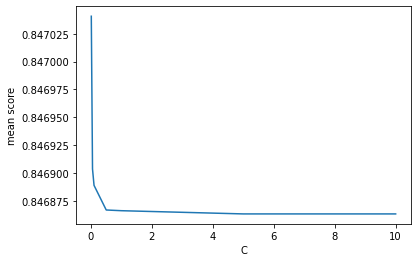

In [12]:
plotGridCv(param_grid, 'C', grid_cv)

In [13]:
grid_cv.cv_results_['mean_test_score'].max()

0.8470406473525116

## Choosing solver

In [14]:
param_grid = {'C': [0.01],'penalty': ['l2'], 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}
grid_cv=GridSearchCV(log_regressor,param_grid,cv=cv,scoring='roc_auc')
grid_cv.fit(X_train_scaled,Y_train)
grid_cv.best_estimator_

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

LogisticRegression(C=0.01, class_weight='balanced', solver='liblinear')

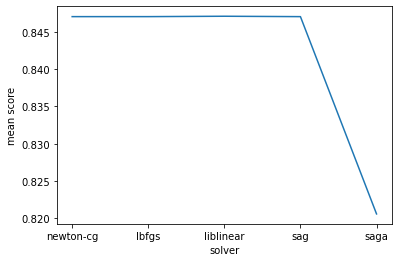

In [15]:
plotGridCv(param_grid, 'solver', grid_cv)

In [16]:
grid_cv.cv_results_['mean_test_score'].max()

0.8470921829039387

# Decision tree

## Choosing max depth

In [17]:
param_grid = {'max_depth':[1,2,3,4,5]}
decision_tree = tree.DecisionTreeClassifier()
grid_cv=GridSearchCV(decision_tree,param_grid,cv=cv,scoring='roc_auc')
grid_cv.fit(X_train_scaled,Y_train)
grid_cv.best_estimator_

DecisionTreeClassifier(max_depth=4)

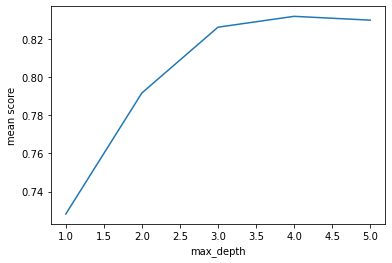

In [18]:
plotGridCv(param_grid, 'max_depth', grid_cv)

In [19]:
grid_cv.cv_results_['mean_test_score'].max()

0.8320521978785365

## Choosing criterion

In [20]:
param_grid = {'max_depth':[4], 'criterion': ['gini', 'entropy']}
decision_tree = tree.DecisionTreeClassifier()
grid_cv=GridSearchCV(decision_tree,param_grid,cv=cv,scoring='roc_auc')
grid_cv.fit(X_train_scaled,Y_train)
grid_cv.best_estimator_

DecisionTreeClassifier(max_depth=4)

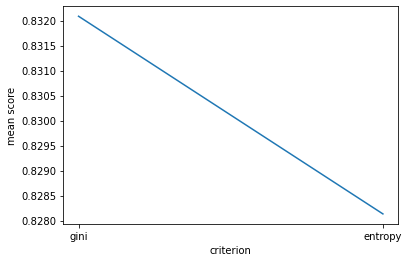

In [21]:
plotGridCv(param_grid, 'criterion', grid_cv)

In [22]:
grid_cv.cv_results_['mean_test_score'].max()

0.8320861249353643

## Choosing min_samples_split

In [23]:
param_grid = {'max_depth':[4], 'criterion': ['gini'],'min_samples_split' : [2,3,4,5,6,7]}
decision_tree = tree.DecisionTreeClassifier()
grid_cv=GridSearchCV(decision_tree,param_grid,cv=cv,scoring='roc_auc')
grid_cv.fit(X_train_scaled,Y_train)
grid_cv.best_estimator_

DecisionTreeClassifier(max_depth=4, min_samples_split=3)

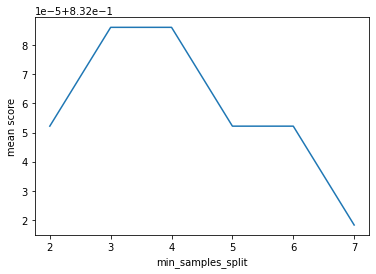

In [24]:
plotGridCv(param_grid, 'min_samples_split', grid_cv)

In [25]:
grid_cv.cv_results_['mean_test_score'].max()

0.8320861249353643

# Random forest


## Choosing n_estimators

In [26]:
rf_classifier = ensemble.RandomForestClassifier()
param_grid = {'n_estimators': [20,30,40,50,60]}
grid_cv=GridSearchCV(rf_classifier,param_grid,cv=cv,scoring='roc_auc')
grid_cv.fit(X_train_scaled,Y_train)
grid_cv.best_estimator_

RandomForestClassifier(n_estimators=60)

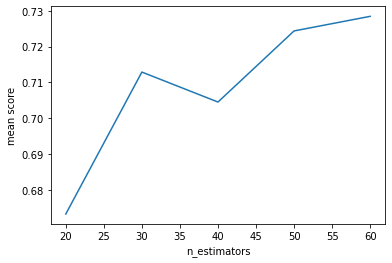

In [27]:
plotGridCv(param_grid, 'n_estimators', grid_cv)

In [28]:
grid_cv.cv_results_['mean_test_score'].max()

0.7284499439473503

## Choosing max_depth

In [29]:
rf_classifier = ensemble.RandomForestClassifier()
param_grid = {'n_estimators': [60], 'max_depth': [2,3,4,5,6]}
grid_cv=GridSearchCV(rf_classifier,param_grid,cv=cv,scoring='roc_auc')
grid_cv.fit(X_train_scaled,Y_train)
grid_cv.best_estimator_ 

RandomForestClassifier(max_depth=6, n_estimators=60)

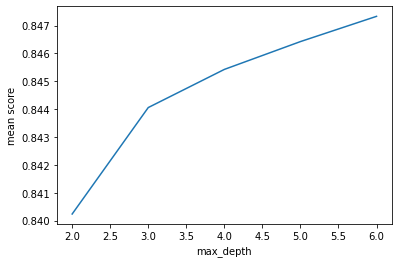

In [30]:
plotGridCv(param_grid, 'max_depth', grid_cv)

In [31]:
grid_cv.cv_results_['mean_test_score'].max()

0.8473316921857309

## Choosing min_samples_split

In [32]:
rf_classifier = ensemble.RandomForestClassifier()
param_grid = {'n_estimators': [60], 'max_depth': [4], 'min_samples_split':[2,3,4,5,6,7]}
grid_cv=GridSearchCV(rf_classifier,param_grid,cv=cv,scoring='roc_auc')
grid_cv.fit(X_train_scaled,Y_train)
grid_cv.best_estimator_ 

RandomForestClassifier(max_depth=4, n_estimators=60)

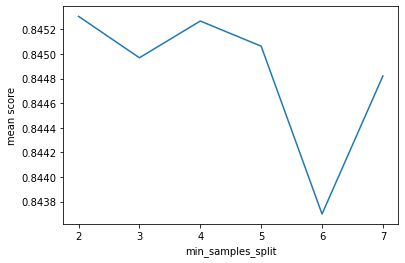

In [33]:
plotGridCv(param_grid, 'min_samples_split', grid_cv)

In [34]:
grid_cv.cv_results_['mean_test_score'].max()

0.84530634574231

# Submitting results

Random forest model with n_estimators=60, max_depth=4, min_samples_split=4 returned the best score = 0.8474851306567525

In [35]:
Y_test = grid_cv.predict_proba(X_test_scaled)[:,1]

In [36]:
sample['stroke']= Y_test
sample.to_csv('submission.csv', index =None)

Private Score:
0.85438
Public Score:
0.86180